# LifeSnaps Preprocessing Data v1.0
- Preprocessem i millorem la neteja de dades previa, sense més elimiació de columnes
- Optimitzem el model per f1
- Es pot executar fora de l'entorn virtual.

### Import de llibreries i warnings

In [1]:
# Exploració de dades
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessament de dades
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,  OneHotEncoder
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Model
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Analisis del model
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, make_scorer
import joblib

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Lectura del dataset cleaned i visualització dades ràpida

In [3]:
df = pd.read_csv('../data/df_cleaned.csv')
pd.set_option('display.max_columns', None)


In [4]:
target_col = ['TIRED']
categoric_col = ['age', 'gender', 'bmi_tipo']
numeric_col = df.drop(columns=categoric_col + target_col).columns.tolist()

## Preprocessament de dades

### Tractament de Valors Absents

Farem imputació simple sobre els valors absents per la mitjana a els valors numerics com heart rate i moda en els valors categorics

In [5]:
X_full = df.drop(columns=target_col)
X_full.shape


(7410, 23)

In [6]:
# Transformem les columnes amb pipeline

numeric_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),
                        ("scaler", StandardScaler())])

categoric_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),
                            ("encoder", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer([
    ("num", numeric_pipe, numeric_col),
    ("cat", categoric_pipe, categoric_col)
])
display(preprocessor)


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['nightly_temperature', 'nremhr', 'rmssd',
                                  'spo2', 'full_sleep_breathing_rate',
                                  'stress_score', 'daily_temperature_variation',
                                  'calories', 'bpm', 'sedentary_minutes',
                                  'resting_hr', 'minutesAsleep', 'minutesAwake',
                                  'sleep_efficiency', 'sleep_deep_ratio',
                                  'sleep_wake_ratio', 'sleep_light_ratio',
                                  'sleep_rem_ratio', 'steps', 'bmi']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['age', 'gender', 'bmi_tipo'])])

In [7]:
# Visualitzem el dataset preprocessat
X_proc = preprocessor.fit_transform(X_full)

df_lbl=df.dropna(subset=target_col, how='all')
X_proc = preprocessor.transform(df_lbl.drop(columns=target_col))


feat_names = preprocessor.get_feature_names_out()

df_final = pd.concat([pd.DataFrame(X_proc, columns=feat_names, index=df_lbl.index), df_lbl[target_col]], axis=1)


In [8]:
df_final.describe()

,num__nightly_temperature,num__nremhr,num__rmssd,num__spo2,num__full_sleep_breathing_rate,num__stress_score,num__daily_temperature_variation,num__calories,num__bpm,num__sedentary_minutes,num__resting_hr,num__minutesAsleep,num__minutesAwake,num__sleep_efficiency,num__sleep_deep_ratio,num__sleep_wake_ratio,num__sleep_light_ratio,num__sleep_rem_ratio,num__steps,num__bmi,cat__age_<30,cat__age_>=30,cat__gender_FEMALE,cat__gender_MALE,cat__bmi_tipo_Infrapes,cat__bmi_tipo_Normal,cat__bmi_tipo_Obes,cat__bmi_tipo_Sobrepes,TIRED
count,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000
mean,0.056990,-0.178412,0.157663,0.011508,-0.180395,0.075523,-0.033280,0.411056,-0.166157,-0.134879,-0.175002,-0.006655,0.016279,-0.022964,-0.098560,-0.036390,-0.052566,-0.065730,0.141542,-0.023198,0.470742,0.529258,0.366376,0.633624,0.055895,0.652838,0.058079,0.233188,0.384279
std,1.236124,1.228692,1.248700,1.332338,1.070924,1.284106,1.284829,1.063042,1.141519,1.139337,1.264384,1.300077,1.243536,1.323252,1.332753,1.258254,1.241622,1.271565,1.197377,0.889318,0.499252,0.499252,0.481919,0.481919,0.229769,0.476172,0.233943,0.422953,0.486531
min,-7.339185,-4.404582,-2.241003,-4.110478,-3.696871,-6.420981,-6.592282,-1.752764,-4.141453,-5.346570,-3.762562,-3.745062,-3.754179,-12.083326,-8.447253,-6.372876,-6.931828,-7.536260,-1.895111,-1.416384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.382921,-0.462126,-0.168273,-0.033152,-0.561710,-0.014007,-0.819410,-0.320835,-0.803517,-0.746195,-0.866645,-0.619251,-0.639237,-0.292132,0.073792,0.092719,0.097098,0.107287,-0.673202,-0.931484,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.073392,-0.016700,-0.168273,-0.033152,-0.016464,-0.014007,0.039736,0.229050,-0.110538,-0.083620,0.025151,0.005911,-0.029791,0.114461,0.073792,0.092719,0.097098,0.107287,-0.132793,-0.022298,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.774130,-0.016700,0.071629,-0.033152,-0.016464,-0.014007,0.836441,1.020419,0.396263,0.285313,0.558986,0.612686,0.579654,0.521053,0.073792,0.092719,0.097098,0.107287,0.703455,0.583826,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,3.607282,4.897892,6.918901,12.878379,5.708614,5.111572,3.858806,5.036436,9.216435,3.425013,3.092205,7.158501,6.267810,2.147425,2.474007,2.391982,2.346972,2.339885,5.696868,2.099137,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
print(df_final.isnull().mean()*100)

num__nightly_temperature            0.0
num__nremhr                         0.0
num__rmssd                          0.0
num__spo2                           0.0
num__full_sleep_breathing_rate      0.0
num__stress_score                   0.0
num__daily_temperature_variation    0.0
num__calories                       0.0
num__bpm                            0.0
num__sedentary_minutes              0.0
num__resting_hr                     0.0
num__minutesAsleep                  0.0
num__minutesAwake                   0.0
num__sleep_efficiency               0.0
num__sleep_deep_ratio               0.0
num__sleep_wake_ratio               0.0
num__sleep_light_ratio              0.0
num__sleep_rem_ratio                0.0
num__steps                          0.0
num__bmi                            0.0
cat__age_<30                        0.0
cat__age_>=30                       0.0
cat__gender_FEMALE                  0.0
cat__gender_MALE                    0.0
cat__bmi_tipo_Infrapes              0.0


## Entrenament del Model

In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
smote = SMOTE(random_state=42)

classifiers = {
    "MLP": (MLPClassifier(max_iter=1000, random_state=42), {
        "clf__hidden_layer_sizes": [(100,), (100, 50)],
        "clf__alpha": [1e-4, 1e-3, 1e-2]
    }),
    "SVM": (SVC(kernel="rbf", probability=True, random_state=42), {
        "clf__C": [1, 10, 100],
        "clf__gamma": ["scale", 0.01]
    }),
    "RandomForest": (RandomForestClassifier(class_weight="balanced",
                                            random_state=42), {
        "clf__n_estimators": [400, 800],
        "clf__max_depth": [None, 20]
    }),
    "GradientBoosting": (GradientBoostingClassifier(random_state=42), {
        "clf__n_estimators": [200, 400],
        "clf__learning_rate": [0.05, 0.1],
        "clf__max_depth": [3, 5]
    }),
}



================= TIRED =================
MLP                recall=0.489   f1=0.490  | best params: {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (100,)}
SVM                recall=0.545   f1=0.509  | best params: {'clf__C': 1, 'clf__gamma': 0.01}
RandomForest       recall=0.460   f1=0.492  | best params: {'clf__max_depth': None, 'clf__n_estimators': 400}
GradientBoosting   recall=0.511   f1=0.513  | best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 400}

Classification report del mejor model:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       282
           1       0.51      0.51      0.51       176

    accuracy                           0.63       458
   macro avg       0.61      0.60      0.61       458
weighted avg       0.63      0.63      0.63       458



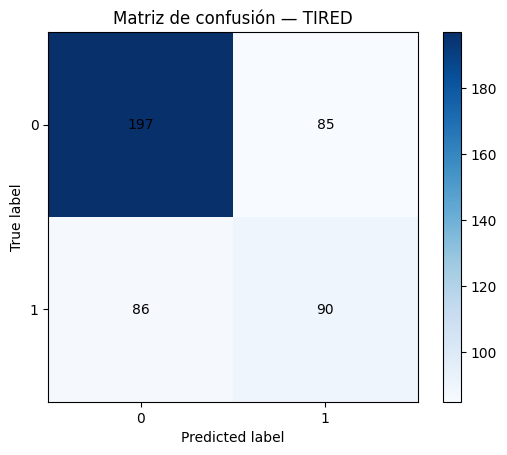


===== TOP models (segons recall) =====
TIRED           -> GradientBoostingClassifier  (recall=0.513)


In [ ]:
best_models = {}
f1_class1_scorer = make_scorer(f1_score, pos_label=1)

for target in target_col:
    print(f"\n================= {target} =================")
    # Prepararem X, y
    y = df_final[target].astype(int)
    X = df_final.drop(columns=target_col)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    best_f1 = -1
    best_pipe   = None

    for name, (clf, grid) in classifiers.items():
        # Pipeline de SMOTE i clasificador
        pipe = ImbPipeline([
            ("sm", smote),
            ("clf", clf)
        ])

        
        # GridSearch per optimitzar f1 (tot hi que recall es una dada importatnt a analitzar)
        grid_search = GridSearchCV(
            pipe,
            param_grid=grid,
            scoring=f1_class1_scorer,
            cv=cv,
            n_jobs=-1,
            verbose=0
        )
        grid_search.fit(X_train, y_train)

        # Evaluació
        y_pred = grid_search.predict(X_test)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, pos_label=1)
        print(f"{name:17s}  recall={rec:.3f}   f1={f1:.3f}  | best params: {grid_search.best_params_}")

        if f1 > best_f1:
            best_f1 = f1
            best_pipe   = grid_search.best_estimator_

    # Informe del millor model
    print("\nClassification report del mejor model:")
    y_best_pred = best_pipe.predict(X_test)
    print(classification_report(y_test, y_best_pred))

    # Visualizació de la matriu de confusió del millor model 
    cm = confusion_matrix(y_test, y_best_pred)
    classes = np.unique(y_test)
    fig, ax = plt.subplots()

    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(classes)),
        yticks=np.arange(len(classes)),
        xticklabels=classes,
        yticklabels=classes,
        xlabel="Predicted label",
        ylabel="True label",
        title=f"Matriz de confusión — {target}"
    )
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    plt.show()

    # Guardem el model a la carpeta /models
    safe_name = target.replace("/", "_") 
    joblib.dump(best_pipe, f"../models/best_{safe_name}.joblib")
    best_models[target] = (best_pipe, best_f1)

# Resumen final
print("\n===== TOP models (segons recall) =====")
for tgt, (model, best_f1) in best_models.items():
    print(f"{tgt:15s} -> {type(model.named_steps['clf']).__name__}  (recall={rec:.3f})")